# **Comprehensive Analysis of the IMDb Top 1000 Movies Dataset**

## **1. Introduction**

What makes a good film great? This question has long been debated among audiences and critics alike. The evaluation of films is often subjective, yet structured rating systems have emerged to provide quantitative assessments. IMDb (Internet Movie Database) and Metacritic are two widely recognised platforms that rate films; however, the methodologies and sources of their ratings differ significantly. IMDb aggregates individual user ratings, reflecting broad audience preferences, while Metacritic consolidates professional critics' reviews, offering an institutional critique. This study aims to explore the differences between these two rating systems and identify factors that contribute to film ratings.

Our primary research question is: Do IMDb scores differ significantly from Metacritic scores? This inquiry seeks to assess whether audience ratings align with critical reviews or whether systematic differences exist between the two. We propose two hypotheses: (1) There is no significant variation between IMDb and Metacritic ratings, and (2) IMDb ratings exhibit higher variability than Metacritic ratings. The underlying rationale is that professional critics follow specific evaluative criteria when rating films, whereas audience members may be influenced by emotional or subjective factors, leading to greater variability in their assessments. 

To conduct this analysis, we compiled a dataset of the top 1,000 IMDb-ranked films, ensuring that each film had corresponding Metacritic scores. Our analytical framework involves computing measures of central tendency (mean, median, mode), visualising rating distributions using density and scatter plots, and employing statistical tests to assess differences in means. Specifically, we utilise two-sided t-tests at a 5% significance level, a standard threshold that balances the risk of Type I and Type II errors.

Furthermore, we extend our analysis to investigate how film ratings have evolved over time. The secondary research question examines whether the disparity between IMDb and Metacritic ratings has widened across different time periods. Given that cinematic trends and audience preferences have shifted over decades, we hypothesise that the difference in ratings has increased. To test this hypothesis, we categorise films by their date of release and apply the same statistical methods as in our primary analysis. If the results indicate a statistically significant change (p-value < 0.05), we conclude that film ratings have evolved over time; otherwise, we reject this hypothesis.

Lastly, we explore the factors that best predict film ratings. Our third research question seeks to identify the most reliable predictor of a film’s rating, with a specific focus on runtime as a potential key variable. We employ multiple regression modelling, incorporating various factors such as revenue and release year while ensuring minimal collinearity. Backward selection based on p-values (threshold of 0.05) is used to refine our model, and adjusted R-squared values help determine the model’s predictive strength. If runtime significantly contributes to higher adjusted R-squared values, we accept our hypothesis; otherwise, we reject it in favour of other explanatory variables.

Through these analyses, this study aims to provide insights into the nature of film ratings, the evolving preferences of audiences and critics, and the statistical relationships between film characteristics and critical reception. The findings contribute to a deeper understanding of how films are evaluated and what distinguishes the best from the rest.



In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sp
import statsmodels.api as sm

movies_full = pd.read_csv('data/imdb1000_data.csv')

### **1.1 Dataset Overview**

The dataset contains 1000 entries, each corresponding to one of the top 1000 movies on IMDb. The columns include:

- **Series_Title**: Movie title.
- **Released_Year**: Year of release (some missing values).
- **Certificate**: Movie’s censorship rating (e.g., R, PG‐13, etc.).
- **Runtime**: Duration of the movie in minutes.
- **Genre**: Category or genres to which the film belongs (Drama, Action, etc.).
- **IMDB_Rating**: Movie rating on IMDb (1–10 scale).
- **Meta_score**: Critics’ rating on Metacritic (1–100 scale).
- **Director**: Director’s name.
- **Star1**, **Star2**: Names of the two lead actors/actresses.
- **Gross**: Box‐office earnings in USD.

The dataset also included some attributes (e.g., `Poster_Link`, `Overview`, `Star3`, `Star4`, `No_of_Votes`) that were dropped for this analysis due to redundancy or missingness.


In [3]:
movies = movies_full.drop(columns=['Poster_Link', 'Overview', 'Star3', 'Star4', 'No_of_Votes'])
movies = movies.set_index('Series_Title')
movies.head(3)

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Gross
Series_Title,,,,,,,,,,
The Shawshank Redemption,1994,A,142 min,Drama,9.3,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,"28,341,469"
The Godfather,1972,A,175 min,"Crime, Drama",9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,"134,966,411"
The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,"534,858,444"


### **1.2 Initial Data Cleaning**

1. **Removal of Irrelevant Columns**: We dropped columns like `Poster_Link`, `Star3`, `Star4`, and `No_of_Votes` because they were not central to our primary objectives or had excessive missing values.  
2. **Index Reset**: We set `Series_Title` as the index, ensuring each row could be uniquely identified by the movie’s title.  
3. **Handling Missing Values**: Columns such as `Certificate`, `Meta_score`, and `Gross` had substantial missing values (over 100 entries missing in some cases). We noted these but did not necessarily drop the corresponding rows outright, recognizing that we might want to keep as many observations as possible.  
4. **Data Type Conversions**:  
   - **Runtime**: Transformed from strings like `"142 min"` to integer (e.g., `142`).  
   - **Gross**: Removed commas (e.g., `"123,456,789"`) and converted to a numeric type.  
   - **Released_Year**: Ensured numeric form for chronological or time‐series analyses.

The outcome was a cleaner, more consistent dataset of roughly 1000 entries.


In [4]:
movies['Released_Year'] = pd.to_numeric(movies['Released_Year'], errors='coerce')
# movies['No_of_Votes'] = pd.to_numeric(movies['No_of_Votes'], errors='coerce')
movies['Released_Year'].dropna().unique()
movies['Runtime'] = movies['Runtime'].str.split(' ').str[0].astype(int)
movies['Gross'] = movies['Gross'].str.replace(',', '')
movies['Gross'] = pd.to_numeric(movies['Gross'], errors='coerce')
movies.head(3)

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Gross
Series_Title,,,,,,,,,,
The Shawshank Redemption,1994.0,A,142,Drama,9.3,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,28341469.0
The Godfather,1972.0,A,175,"Crime, Drama",9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,134966411.0
The Dark Knight,2008.0,UA,152,"Action, Crime, Drama",9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,534858444.0



## **2. Exploratory Data Analysis (EDA)**

### **2.1 Overview of Missing Values**

A quick inspection highlighted some missing data:

- **Released_Year**: 1 missing
- **Certificate**: 101 missing
- **Meta_score**: 157 missing
- **Gross**: 169 missing

The missing data in `Gross` and `Meta_score` especially could complicate advanced analyses (e.g., exploring the link between box‐office success and critical reception).


In [5]:
# print('The number of missing values: ')
# for item in movies.columns:
#     print(f'{item} - {movies[item].isnull().sum()}')

### **2.2 Sorting and General Inspection**

Sorting by `Released_Year` in descending order helped confirm that the dataset includes titles spanning from the mid‐20th century all the way to recent years (e.g., 2020 releases). We also noted that many of the newer releases lacked `Gross` data—likely due to incomplete box office figures or exclusive streaming releases.


In [6]:
movies.sort_values(by='Released_Year', ascending=False)['Gross'].head(5)

Series_Title
Druk                         NaN
Hamilton                     NaN
Dil Bechara                  NaN
Soul                         NaN
The Trial of the Chicago 7   NaN
Name: Gross, dtype: float64

## **3. Comparing IMDb Ratings vs. Metascore**

A primary focus was understanding how **IMDb ratings** (audience‐driven) and **Metascores** (critic‐driven) relate to each other for these top 1000 movies.

### **3.1 Rescaling IMDb Rating**

To facilitate direct comparison, we rescaled `IMDB_Rating` from a 10‐point scale to a 100‐point scale (multiplied by 10). We then merged `Meta_score` and this new scaled `IMDB_Rating` into a single DataFrame (`critics_score`).

In [7]:
meta_score = movies['Meta_score']
imdb_score = movies['IMDB_Rating'] * 10
critics_score = pd.concat([meta_score, imdb_score], axis=1)
critics_score = critics_score.dropna()
critics_score.head()

,Meta_score,IMDB_Rating
Series_Title,,
The Shawshank Redemption,80.0,93.0
The Godfather,100.0,92.0
The Dark Knight,84.0,90.0
The Godfather: Part II,90.0,90.0
12 Angry Men,96.0,90.0


### **3.2 Descriptive Statistics**

- **IMDb_Rating (scaled 1–100)**:  
  - Mean: ~79.3  
  - Std Dev: ~2.84  
  - Range: 76 – 93  

- **Meta_score (1–100)**:  
  - Mean: ~77.9  
  - Std Dev: ~12.4  
  - Range: 28 – 100  

Visually, IMDb scores are quite clustered (reflecting that these are top‐ranked films, typically falling between 7 and 9 on IMDb). Metacritic scores, however, exhibit a broader distribution (some well‐received by audiences but panned by critics, or vice versa).


In [8]:
# critics_score.describe()

### **3.3 Distribution Plots**

From **Fig 1: Density plot of Movie Rating Distribution** and **Fig 2: Violin plot of Movie Rating Distribution**, we see:

- **IMDb**: Ratings cluster tightly around ~7.5–8.5 (on the 10‐point scale).  
- **Metascore**: Spans from as low as ~30 to as high as 100. Critics seem less uniformly “positive” even for top movies, indicating a broader spread of critical opinion.

Hence, critics (on Metacritic) demonstrate more variation, while audience ratings on IMDb top 1000 films tend to be high and less variable.

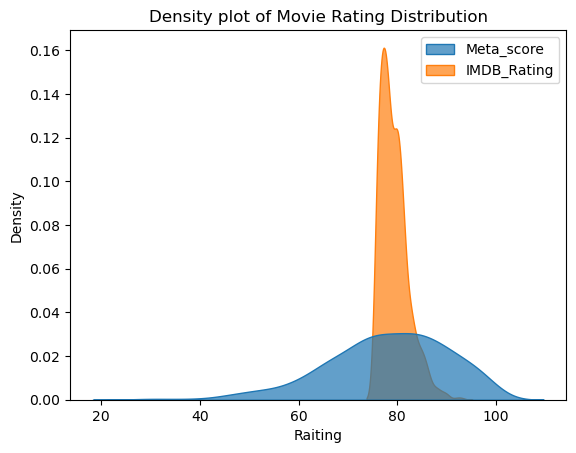

In [9]:
sns.kdeplot(data=critics_score, fill=True, alpha=0.7, common_norm=False)
plt.title('Density plot of Movie Rating Distribution')
plt.ylabel('Density')
plt.xlabel('Raiting')
plt.show()

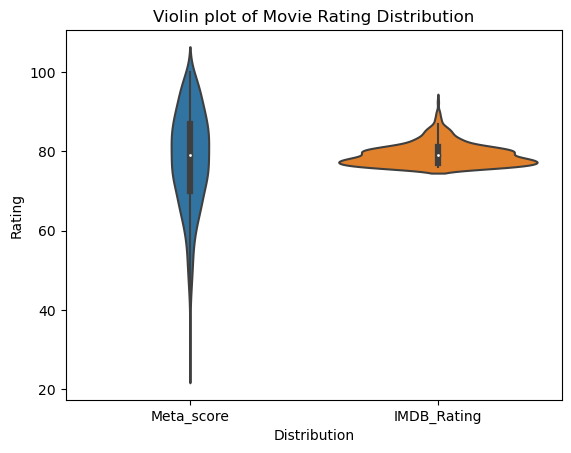

In [10]:
sns.violinplot(data=critics_score)
plt.title('Violin plot of Movie Rating Distribution')
plt.ylabel('Rating')
plt.xlabel('Distribution')
plt.show()

## **4. T‐Tests: Statistical Comparison of Two Ratings**

We employed **t‐tests** to check whether the difference between average IMDb ratings and average Metascores is statistically significant.

The resultant p‐value  was ~ 0.0021, showing that this difference persists even across different time periods.
Takeaway: In every scenario tested, IMDb’s user ratings differ consistently from the critics’ Metascore, suggesting distinct standards or biases in how audiences vs. professionals evaluate these top‐ranked films.

In [11]:
t_test = sp.ttest_ind(critics_score["IMDB_Rating"], critics_score["Meta_score"], alternative = "two-sided")
t_test.pvalue

0.002131446476396098

## **5. Time‐Series Examination: Rating Fluctuations Over Years**

### **5.1 Grouping by Year**
FiG 3: How did movie ratings change over time shows mean IMDb Rating (scaled) and mean Metascore by release date


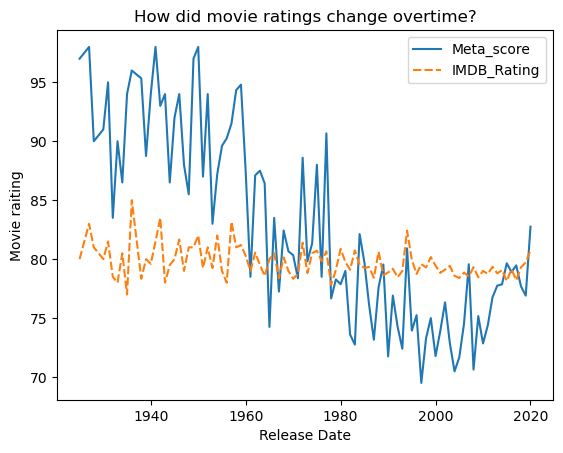

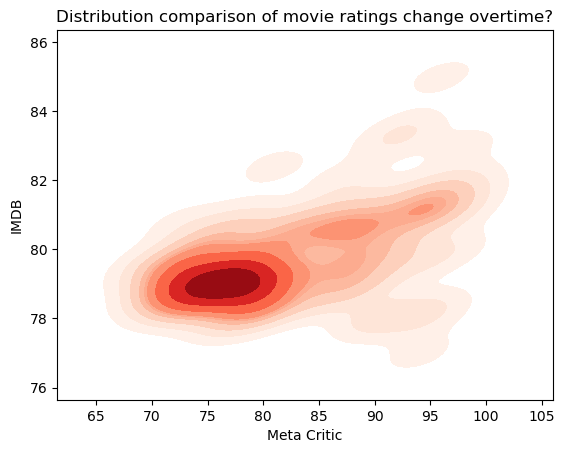

In [12]:
movies_time = pd.concat([meta_score, imdb_score, movies['Released_Year']], axis=1).dropna()

movies_by_year = movies_time.groupby('Released_Year').agg({
	'Meta_score': 'mean',
	'IMDB_Rating': 'mean'
}).reset_index()

movies_by_year = movies_by_year.set_index('Released_Year')
sns.lineplot(data=movies_by_year)
plt.title('How did movie ratings change overtime?')
plt.ylabel('Movie raiting')
plt.xlabel('Release Date')
plt.show()
sns.kdeplot(x=movies_by_year['Meta_score'], y=movies_by_year['IMDB_Rating'], cmap="Reds", fill=True, bw_adjust=0.7)
plt.title('Distribution comparison of movie ratings change overtime?')
plt.xlabel('Meta Critic')
plt.ylabel('IMDB')
plt.show()

### **5.2 Observations**
- IMDb: Tends to hover between mid‐70s and mid‐80s (when scaled to 100), i.e., ~7.5–8.5 in the 1–10 domain.  
- Metascore: Shows greater variability across different eras, suggesting that critical reception may be influenced by changing cinematic trends, evolving review criteria, or shifting public taste in older vs. contemporary films.  
**Fig 4: Distribution comparison of movie ratings change overtime?** shows that comparing IMDB_Rating vs. Meta_score reveals the densest cluster in the region ~[IMDb: 78–82, Meta: 70–85]. Still, the Metascore extends down to ~30 for a small set of titles that audiences adore but critics spurn.  


In [13]:
t_test = sp.ttest_ind(movies_by_year["IMDB_Rating"], movies_by_year["Meta_score"], alternative = "two-sided")
t_test.pvalue

0.0007288994624564086

## **6. Simple Linear Regression: IMDb Rating on Runtime**
We built an initial Ordinary Least Squares (OLS) model to see if runtime alone explains variation in IMDb ratings:

Key Results  
- Runtime Coefficient: ~0.0024–0.003  
- Each additional minute corresponds to a ~0.003 point increase in IMDb rating.  
- Intercept: ~7.65  
- R‐Squared: ~0.059, meaning runtime explains only about 5.9% of the variation in IMDb ratings.  
Interpretation: While there is a mild positive trend (longer movies tend to be slightly more highly rated by audiences), the effect size is small, and a large majority of the variance remains unexplained.
Residual Analysis  
A histogram of residuals **Fig 7: Histogram showing distribution of residuals** displayed a right‐skew, violating normality assumptions and highlighting that we may need more predictors (or different model forms) to better capture what drives IMDb ratings.


In [14]:
formula_string = "IMDB_Rating ~ Runtime"
model = sm.formula.ols(formula = formula_string, data = movies)
model_fitted = model.fit()

model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            IMDB_Rating   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.058
Method:                 Least Squares   F-statistic:                     62.68
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           6.44e-15
Time:                        21:06:53   Log-Likelihood:                -98.782
No. Observations:                1000   AIC:                             201.6
Df Residuals:                     998   BIC:                             211.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6563      0.038    201.718      0.000       7.582       7.731
Runtime        0.0024      0.000      7.917      0.000       0.002       0.003
==============================================================================
Omnibus:                      128.871   Durbin-Watson:                   0.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.884
Skew:                           0.911   Prob(JB):                     5.85e-42
Kurtosis:                       4.114   Cond. No.                         566.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

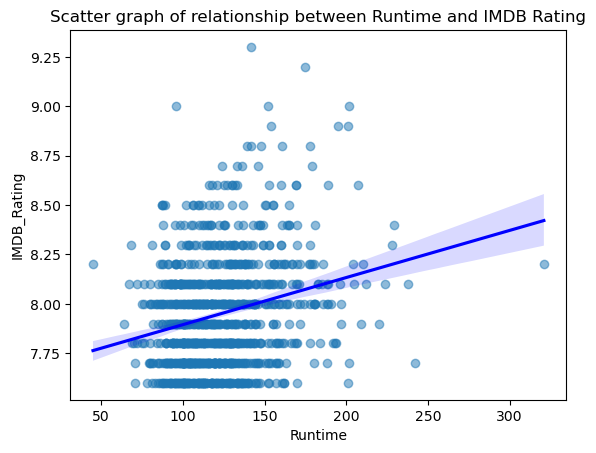

In [15]:
sns.regplot(x = movies['Runtime'] , y = movies['IMDB_Rating'] , scatter_kws={'alpha':0.5}, line_kws={'color': 'blue'})
plt.title('Scatter graph of relationship between Runtime and IMDB Rating')
plt.show()

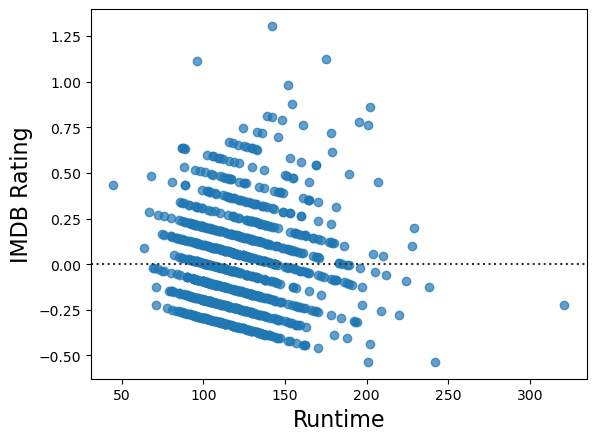

In [16]:
# model diagnostics, assessing the conditions for linear regression
sns.residplot(data = movies, x = 'Runtime' , y = 'IMDB_Rating', scatter_kws={'alpha': 0.7})
plt.xlabel('Runtime', fontsize = 16)
plt.ylabel('IMDB Rating', fontsize = 16)
plt.title('')
plt.show()

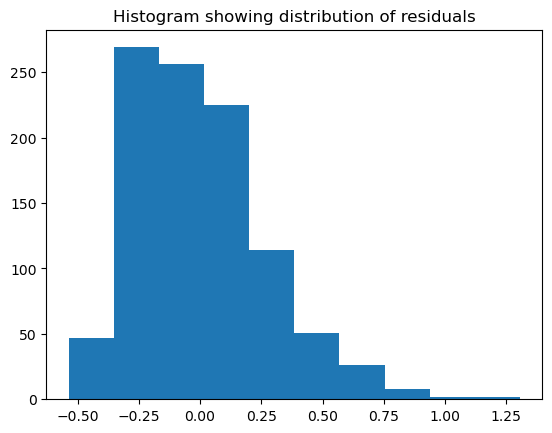

In [17]:
x = movies['Runtime']
y = movies['IMDB_Rating']
y_pred = model_fitted.predict(x)
residuals = y - y_pred
plt.hist(residuals, bins = 10)
plt.title('Histogram showing distribution of residuals')
plt.show();


## **7. Feature Engineering for a More Complex Model**
Given runtime’s limited explanatory power, we introduced additional predictors:
1. Certificate Category  
    - Grouped movie certificates into a binary feature (certificate_category):    
    - 1 for “kid‐friendly” or “all‐audience” certificates (e.g., U, UA, PG, etc.).    
	- 0 for “adult‐oriented” ratings (R, TV‐MA, etc.).    
	- This metric captured age‐appropriateness which could affect audience size and sentiment.    
2. Star Power  
	- Counted how many times each actor appeared in the top 1000 dataset.    
	- Created tiers: 1 appearance, 2–5 appearances, >5 appearances.    
	- Combined the lead actors’ tiers into a single variable, Stars_Level, aiming to measure the “actor popularity” factor.    
3. Director Level  
	- Similarly, categorized directors by how many times their films appear in the top 1000 (1, 2–5, >5).    
	- This new feature, Director_Level, reflects how frequently a particular director has achieved top‐rated success.    
These features, along with Gross (box‐office revenue) and Released_Year, provide multiple dimensions that might correlate with a film’s popularity among IMDb users.


In [18]:
movies = movies.dropna()
movies = movies.copy()

kid_movies = ['A', 'UA', 'U/A' , 'U' , 'PG-13' , 'TV-14', 'PG' ,'TV-PG', 'G' ,'Passed', 'Approved']
adult_movies = ['R', '16', 'GP', 'TV-MA', 'Unrated']
def classify_cert(row):
    if row in kid_movies:
        return 1
    elif row in adult_movies:
        return 0
    else:
        print('There is a NaN value')
        return np.nan
    
movies['Certificate_category'] = movies['Certificate'].apply(classify_cert)
movies.head()

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Gross,Certificate_category
Series_Title,,,,,,,,,,,
The Shawshank Redemption,1994.0,A,142,Drama,9.3,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,28341469.0,1
The Godfather,1972.0,A,175,"Crime, Drama",9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,134966411.0,1
The Dark Knight,2008.0,UA,152,"Action, Crime, Drama",9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,534858444.0,1
The Godfather: Part II,1974.0,A,202,"Crime, Drama",9.0,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,57300000.0,1
12 Angry Men,1957.0,U,96,"Crime, Drama",9.0,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,4360000.0,1


In [19]:
n_as_star1 = movies['Star1'].value_counts()
n_as_star2 = movies['Star2'].value_counts()
rs_combined = n_as_star1.add(n_as_star2, fill_value=0)
categorised_stars = pd.cut(rs_combined, [0, 1, 5, 15], labels=[1, 2, 3])
# Here's a breakdown on these categories
categorised_stars.value_counts()

1    694
2    219
3     21
dtype: int64

In [20]:
# This will calculate the sum of their appearences as both star1 and star2
def categorise_stars(row):
    star1 = categorised_stars[row['Star1']]
    star2 = categorised_stars[row['Star2']]

    return star1 + star2

movies['Stars_Level'] = movies.apply(categorise_stars, axis=1)

In [21]:
def categorise_director(row):
    categorised_director = pd.cut(movies['Director'].value_counts(), [0, 1, 5, 20], labels=[1, 2, 3])
    return categorised_director[row]

movies['Director_Level'] = movies['Director'].apply(categorise_director)

## **8. Multiple Regression Model**
We constructed a more comprehensive OLS model including runtime, certificate_category, gross, released_year, director_level, and stars_level:  

### **8.1 Full Model and Backward Selection**
- R‐squared: ~0.143, Adjusted: ~0.136    
- Some predictors (e.g., Stars_Level, certificate_category) were not statistically significant (p > 0.05).    
- Condition number was very high, suggesting multicollinearity or potential numeric instability.       

In [22]:
formula_string = "IMDB_Rating ~ Runtime + Certificate_category + Gross + Released_Year + Director_Level + Stars_Level"

model = sm.formula.ols(formula = formula_string, data = movies)
model_fitted = model.fit()


model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            IMDB_Rating   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     19.61
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           3.14e-21
Time:                        21:06:55   Log-Likelihood:                -81.510
No. Observations:                 713   AIC:                             177.0
Df Residuals:                     706   BIC:                             209.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               12.9804      1.170     11.098      0.000      10.684      15.277
Runtime                  0.0025      0.000      6.037      0.000       0.002       0.003
Certificate_category     0.0360      0.028      1.307      0.192      -0.018       0.090
Gross                 2.913e-10   9.85e-11      2.956      0.003    9.78e-11    4.85e-10
Released_Year           -0.0028      0.001     -4.742      0.000      -0.004      -0.002
Director_Level           0.0706      0.015      4.616      0.000       0.041       0.101
Stars_Level             -0.0063      0.010     -0.619      0.536      -0.026       0.014
==============================================================================
Omnibus:                       95.763   Durbin-Watson:                   0.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.534
Skew:                           0.924   Prob(JB):                     1.85e-31
Kurtosis:                       4.161   Cond. No.                     1.59e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### **8.3 Interpretation of Coefficients**
IMDB Rating = Intercept + 
1. Runtime: \~+0.0024–0.003 per additional minute. Movies with longer runtimes tend to have slightly higher IMDb ratings (though the effect size is modest).    
2. Gross: \~+3.09e‐10. Very small but positive; higher box‐office revenue correlates with a marginally higher IMDb rating.   
3. Released_Year: \~−0.0029 per year. Suggests that older classics are slightly more favorably rated, or there is a mild “nostalgia effect.”    
4. Director_Level:\~+0.069–0.07 per step up the category scale.Directors who have multiple films in the top 1000 are slightly more likely to produce higher‐rated works.  

While the adjusted R‐squared (~0.135) indicates that around 13–14% of the variance is explained by this model, it remains modest. The results confirm that no single factor or small set of variables fully determines a film’s popularity, reflecting the complexity of cinematic reception.

In [23]:
formula_string = "IMDB_Rating ~ Runtime + Gross + Released_Year + Director_Level"

model = sm.formula.ols(formula = formula_string, data = movies)
model_fitted = model.fit()


model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            IMDB_Rating   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     28.89
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           2.89e-22
Time:                        21:06:55   Log-Likelihood:                -82.550
No. Observations:                 713   AIC:                             175.1
Df Residuals:                     708   BIC:                             197.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         13.3257      1.142     11.668      0.000      11.084      15.568
Runtime            0.0024      0.000      6.017      0.000       0.002       0.003
Gross           3.099e-10   9.32e-11      3.324      0.001    1.27e-10    4.93e-10
Released_Year     -0.0029      0.001     -5.133      0.000      -0.004      -0.002
Director_Level     0.0693      0.015      4.655      0.000       0.040       0.099
==============================================================================
Omnibus:                       96.901   Durbin-Watson:                   0.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.775
Skew:                           0.932   Prob(JB):                     6.02e-32
Kurtosis:                       4.170   Cond. No.                     1.56e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Predictor T values

In [24]:
np.abs(model_fitted.tvalues)

Intercept         11.668356
Runtime            6.016673
Gross              3.323827
Released_Year      5.132638
Director_Level     4.655255
dtype: float64

## **9. Discussion and Limitations**
Despite identifying some measurable relationships, IMDb ratings appear to be influenced by many nuanced elements we haven’t captured—such as:
- Genre: Different genres have distinct audience bases and rating patterns.
- Marketing & Hype: Pre‐release buzz, marketing budgets, or cultural events can boost ratings.
- Awards & Recognition: Academy Awards and other accolades might elevate IMDb scores over time.
- Critical/Influencer Impact: High‐profile reviews or social media influencers can sway public perception.

In addition, we observed:
1. Multicollinearity: The high condition number suggests some predictors could be correlated (e.g., Released_Year and Gross, or Director_Level and Gross).
2. Missing Data: Substantial missingness in Gross and Meta_score can skew or limit the size of our final sample.
3. Non‐normal Residuals: The distribution of residuals from our regressions often displayed skew, violating some OLS assumptions.
4. It is possible that our dataset is responsible for some of these limitations.  

## **10. Conclusions & Future Directions**
- Audience vs. Critics: T‐tests show that IMDb ratings significantly differ from Metascores across the entire dataset and within yearly aggregates, indicating user–critic divergence.  
- Stable IMDb, Variable Metascore: Over time, IMDb ratings remain relatively constrained, while Metascores exhibit broader fluctuation, highlighting critics’ diversity of opinion.  
- Runtime Has a Small but Significant Effect: Longer movies correlate with marginally higher IMDb ratings, but it’s far from a comprehensive explanation.  
- Multiple Regression: Adding Gross, Director_Level, and Released_Year improves the explanatory power slightly (~14% of the variance).  
- Further Feature Engineering: We might incorporate textual analysis (e.g., from plot summaries or user reviews), advanced genre classifications (including multiple genre weighting), or direct social media metrics.  
- Alternative Modeling Approaches: Nonlinear or machine learning methods (e.g., Random Forests, Boosted Trees) could capture interactions among variables (e.g., synergy between star power and director level) more effectively than linear models.  

Final Thought: Movie success and acclaim are the product of countless creative, cultural, and market factors. Our analysis, though limited to a handful of features, uncovers some interesting patterns but also underscores the multifaceted nature of film ratings. By continuing to refine our data sources and analytic methods, we can develop a richer, more predictive understanding of what makes a movie both a commercial and critical hit.